In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlcm import mlcm
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from PIL import Image
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from dataloader import CelebA
PATH_TO_IMAGES = 'data/img_align_celeba'
PATH_TO_LABELS = 'data/list_attr_celeba.csv'


In [ ]:
img = Image.open(PATH_TO_IMAGES + '/000221.jpg')
img.show()

In [ ]:
class_names = open(PATH_TO_LABELS).readlines()[0].split(',')[1:]
class_names = [name.replace('_', ' ') for name in class_names]

random_dummy = np.random.rand(len(class_names))
class_wise_acc = [0.89422319, 0.77121944, 0.77575414, 0.79800868, 0.97887914, 0.90708793,
 0.80382492, 0.79009759, 0.85604791, 0.93434543, 0.95837441, 0.81311613,
 0.86528983, 0.94013703, 0.95255816, 0.97086948, 0.93417291, 0.96537362,
 0.86736002, 0.77001183, 0.92337835, 0.72959385, 0.95475158, 0.90459878,
 0.89131506, 0.7278194,  0.95694499, 0.72045051, 0.92409306, 0.93619381,
 0.94297121, 0.77799685, 0.79798403, 0.81937599, 0.82992409, 0.97860804,
 0.89220229, 0.87881999, 0.93089511, 0.8359375 ]

mean_class_wise_acc = np.mean(class_wise_acc)

In [ ]:
dataset = CelebA(PATH_TO_IMAGES, PATH_TO_LABELS, augment=False)
distribution, num_of_instances = dataset.get_distribution()

In [ ]:

num_of_training_samples = np.array(distribution * 0.7, dtype=int)
num_of_eval_samples = np.array(distribution * 0.2, dtype=int)
num_of_test_samples = np.array(distribution * 0.1, dtype=int)
print(num_of_training_samples)
print(num_of_eval_samples)

cv_df = pd.DataFrame({'class_names': class_names, 'train_samples': num_of_training_samples, 'eval_samples': num_of_eval_samples, 'test_samples': num_of_test_samples})

In [ ]:
pos_samples_for_each_class = np.array(distribution, dtype=int)
print(pos_samples_for_each_class)
print(int(np.average(pos_samples_for_each_class)))
dataset_df = pd.DataFrame({'class_names': class_names, 'pos_samples': pos_samples_for_each_class, 'neg_samples': num_of_instances - pos_samples_for_each_class})


In [ ]:
plt.figure(figsize=(20, 8))
barWidth = 0.85


# Create the bar plots
plt.bar(dataset_df['class_names'], dataset_df['pos_samples'], color='#3f9e2c', width=barWidth, label='Positive samples')
#plt.bar(dataset_df['class_names'], dataset_df['neg_samples'], color='#d4d16a', width=barWidth, label='Negative samples')

# Add x-axis and y-axis labels and a title

plt.title('Distribution of Attributes')
plt.axhline(y=int(np.average(pos_samples_for_each_class)), color='r', linestyle='-', label='Average number of positive samples')
# Add legend
plt.legend()
plt.grid(axis='y')
plt.xlabel('Attributes')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Number of instances')
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
barWidth = 0.85


# Create the bar plots
plt.bar(cv_df['class_names'], cv_df['train_samples'], color='#e08790', width=barWidth, label='Training samples')
plt.bar(cv_df['class_names'], cv_df['eval_samples'], color='#d4d16a', width=barWidth, label='Eval samples')

# Add x-axis and y-axis labels and a title

plt.title('Distribution of Attributes')
# Add legend
plt.legend()
plt.grid(axis='y')
plt.xlabel('Attributes')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Number of instances')
plt.show()



In [ ]:
valid_score = pd.read_csv('metadata/class_wise_accuracy.csv')
print(valid_score)

In [119]:
# Class-wise accuracy scores

valid_score = pd.read_csv('metadata/class_wise_accuracy.csv')
v1 = valid_score.loc[1][2:].values
v2 = valid_score.loc[3][2:].values
v3 = valid_score.loc[5][2:].values
v4 = valid_score.loc[7][2:].values


0    MOBILE_NET_V2_1
1    MOBILE_NET_V2_1
2    MOBILE_NET_V2_2
3    MOBILE_NET_V2_2
4    MOBILE_NET_V2_3
5    MOBILE_NET_V2_3
6    MOBILE_NET_V2_4
7    MOBILE_NET_V2_4
Name: model_id, dtype: object


TypeError: iteration over a 0-d array

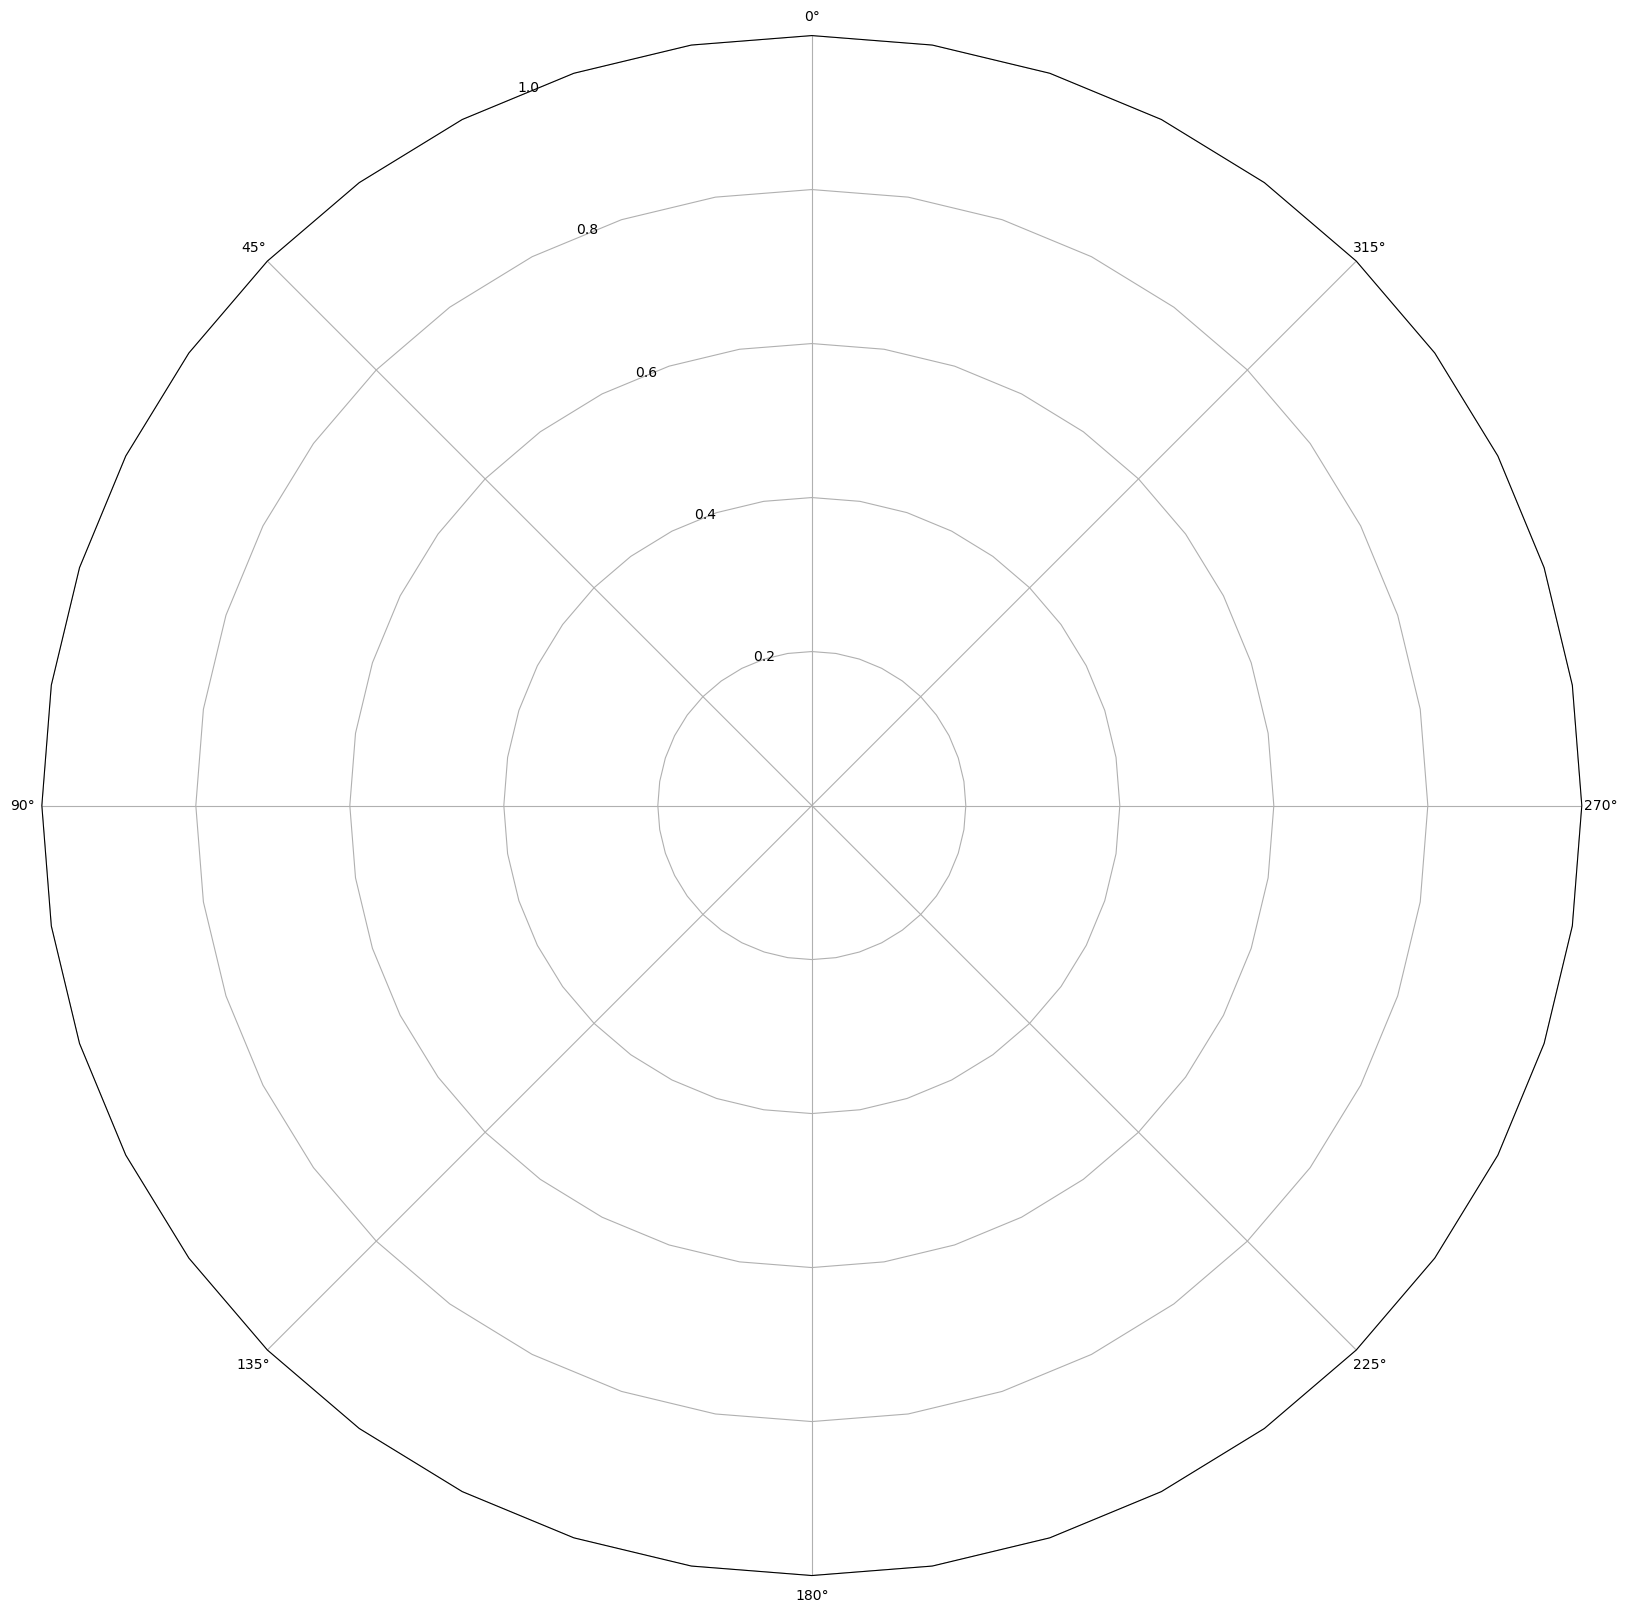

In [118]:

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [
        class_names,
        ('1', [
            v1,
            v2,
            v3,
            v4,
            ]),
    ]
    return data


if __name__ == '__main__':
    N = len(class_names)
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)
    fig, axs = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection='radar'))

    legend_labels = [valid_score[]]
    colors = ['y', 'g', 'b', 'r']
    # Plot the four cases from the example data on separate axes
    
    for ax, (title, case_data) in zip([axs], data):
        fig.canvas.draw()
        ax.set_rgrids([1])
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.15, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    

    fig.text(0.5, 0.965, 'Class-wise accuracy of CelebA dataset',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [116]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
def spaghetti_plot(title, labels, *args):
    if args is None:
        return
    df=pd.DataFrame(
        {
            'x': range(0, len(args[0])),
            labels[0]: args[0],
            labels[1]: args[1],
            labels[2]: args[2],
            labels[3]: args[3]

        })

    # Change the style of plot
    
    # Create a color palette
    palette = plt.get_cmap('Dark2')
    
    # Plot multiple lines
    num=0
    for column in df.drop('x', axis=1):
        num+=1
        plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

    # Add legend
    plt.legend(loc=2, ncol=1)
    
    # Add titles
    plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Score")

    # Show the graph
    plt.show()


2    MOBILE_NET_V2_2
3    MOBILE_NET_V2_2
Name: model_id, dtype: object


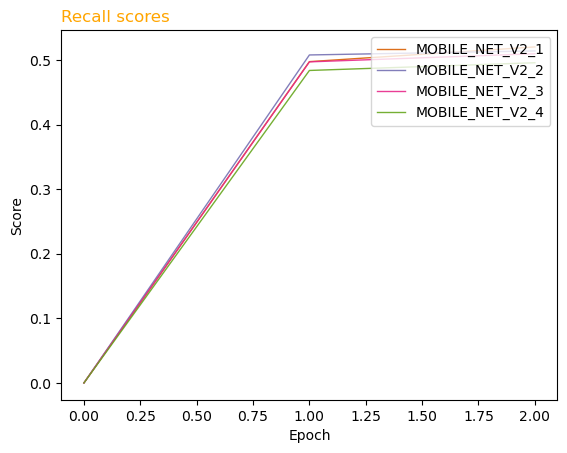

In [115]:
valid_score = pd.read_csv('metadata/validation_scores.csv')

#Recall scores
v1_values = [0]
v2_values = [0]
v3_values = [0]
v4_values = [0]

v1 = valid_score[['model_id', 'recall_score']][0:2]
v1_values.extend(v1['recall_score'].values)

v2 = valid_score[['model_id', 'recall_score']][2:4]
v2_values.extend(v2['recall_score'].values)

v3 = valid_score[['model_id', 'recall_score']][4:6]
v3_values.extend(v3['recall_score'].values)

v4 = valid_score[['model_id', 'recall_score']][6:8]
v4_values.extend(v4['recall_score'].values)

print(v2['model_id'])

labels = [v1['model_id'][0], v2['model_id'][2], v3['model_id'][4], v4['model_id'][6]]

spaghetti_plot('Recall scores', labels, v1_values, v2_values, v3_values, v4_values)


In [ ]:
# Precision scores

valid_score = pd.read_csv('metadata/validation_scores.csv')

v1_values, v2_values, v3_values, v4_values = [0], [0], [0], [0]

v1 = valid_score[['model_id', 'precision_score']][0:2]
v1_values.extend(v1['precision_score'].values)

v2 = valid_score[['model_id', 'precision_score']][2:4]
v2_values.extend(v2['precision_score'].values)

v3 = valid_score[['model_id', 'precision_score']][4:6]
v3_values.extend(v3['precision_score'].values)

v4 = valid_score[['model_id', 'precision_score']][6:8]
v4_values.extend(v4['precision_score'].values)

labels = [v1['model_id'][0], v2['model_id'][2], v3['model_id'][4], v4['model_id'][6]]

spaghetti_plot('Precision scores', labels, v1_values, v2_values, v3_values, v4_values)


In [ ]:
# Partial accuracy scores

valid_score = pd.read_csv('metadata/validation_scores.csv')

v1_values, v2_values, v3_values, v4_values = [0], [0], [0], [0]

v1 = valid_score[['model_id', 'partial_accuracy']][0:2]
v1_values.extend(v1['partial_accuracy'].values)

v2 = valid_score[['model_id', 'partial_accuracy']][2:4]
v2_values.extend(v2['partial_accuracy'].values)

v3 = valid_score[['model_id', 'partial_accuracy']][4:6]
v3_values.extend(v3['partial_accuracy'].values)

v4 = valid_score[['model_id', 'partial_accuracy']][6:8]
v4_values.extend(v4['partial_accuracy'].values)

labels = [v1['model_id'][0], v2['model_id'][2], v3['model_id'][4], v4['model_id'][6]]

spaghetti_plot('Partial accuracy scores', labels, v1_values, v2_values, v3_values, v4_values)